In [36]:
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import matplotlib.pyplot as plt
from scipy import sparse

In [37]:
def calculate_metrics(y_true, y_pred, dataset_name=""):
    # Calculate confusion matrix components
    TP = np.sum((y_pred == 'spam') & (y_true == 'spam'))
    FP = np.sum((y_pred == 'spam') & (y_true == 'ham'))
    TN = np.sum((y_pred == 'ham') & (y_true == 'ham'))
    FN = np.sum((y_pred == 'ham') & (y_true == 'spam'))
    
    # Calculate metrics
    accuracy = np.mean(y_pred == y_true)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Print results
    print(f"Metrics for {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print("\n")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'confusion_matrix': {
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN
        }
    }

# Tập dữ liệu Enron-Spam

In [38]:
df_train = pd.read_csv('Data/train.csv')
df_val = pd.read_csv('Data/val.csv')

df_train.drop(columns=['Message ID', 'Unnamed: 0', 'split'], inplace=True)
df_val.drop(columns=['Message ID', 'Unnamed: 0', 'split'], inplace=True)

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27284 entries, 0 to 27283
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Subject   27055 non-null  object
 1   Message   26932 non-null  object
 2   Spam/Ham  27284 non-null  object
dtypes: object(3)
memory usage: 639.6+ KB


In [40]:
df_train.head()

,Subject,Message,Spam/Ham
0,christmas tree farm pictures,NaN,ham
1,"vastar resources , inc .","gary , production from the high island larger ...",ham
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham
3,re : issue,fyi - see note below - already done .\r\nstell...,ham
4,mcmullen gas for 11 / 99,"jackie ,\r\nsince the inlet to 3 river plant i...",ham


# Tiền xử lý dữ liệu

In [41]:
print(df_train['Spam/Ham'].value_counts())

Spam/Ham
spam    13858
ham     13426
Name: count, dtype: int64


In [42]:
print(f"Number of rows: {len(df_train)}")
print(f"Number of rows: {len(df_val)}")

Number of rows: 27284
Number of rows: 3084


1. Phân tích dữ liệu thiếu

In [43]:
print("\nMissing values in training set:")
print(df_train.isnull().sum())
print("\nMissing values in validation set:")
print(df_val.isnull().sum())


Missing values in training set:
Subject     229
Message     352
Spam/Ham      0
dtype: int64

Missing values in validation set:
Subject     29
Message     35
Spam/Ham     0
dtype: int64


2. Xử lý dữ liệu thiếu

In [44]:
df_train['Subject'] = df_train['Subject'].fillna('')
df_train['Message'] = df_train['Message'].fillna('')
df_val['Subject'] = df_val['Subject'].fillna('')
df_val['Message'] = df_val['Message'].fillna('')

3. Kết hợp Subject và Message

In [45]:
df_train['text'] = df_train['Subject'] + ' ' + df_train['Message']
df_val['text'] = df_val['Subject'] + ' ' + df_val['Message']

4. Chuyển dữ liệu về dạng vector BoW

In [46]:
bow = CountVectorizer(stop_words='english')

In [47]:
X_train = bow.fit_transform(df_train['text'])
X_val = bow.transform(df_val['text'])

y_train = df_train['Spam/Ham']
y_val = df_val['Spam/Ham']

# Naive Bayes Classifier

## Hiện thực mô hình

In [48]:
class MultinomialNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  
        self.class_priors = None
        self.feature_probs = None
        self.classes = None
        
    def fit(self, X, y):
        if X.size == 0:
            raise ValueError("Input array X is empty")
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
            
        n_samples = X.shape[0]
        n_features = X.shape[1]
            
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        self.class_priors = np.zeros(n_classes)
        for i, c in enumerate(self.classes):
            self.class_priors[i] = np.sum(y == c) / n_samples
            

        self.feature_probs = np.zeros((n_classes, n_features))
        for i, c in enumerate(self.classes):
            class_indices = np.where(y == c)[0]
            
            feature_counts = np.zeros(n_features) + self.alpha
            batch_size = 1000
            
            for start_idx in range(0, len(class_indices), batch_size):
                end_idx = min(start_idx + batch_size, len(class_indices))
                batch_indices = class_indices[start_idx:end_idx]
                
                if isinstance(X, np.ndarray):
                    batch_sum = X[batch_indices].sum(axis=0)
                else:
                    batch_sum = X[batch_indices].toarray().sum(axis=0)
                    
                feature_counts += batch_sum
                
            total_counts = feature_counts.sum()
            self.feature_probs[i] = feature_counts / total_counts
            
    def predict(self, X):
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
            
        predictions = []
        batch_size = 1000
        
        for start_idx in range(0, X.shape[0], batch_size):
            end_idx = min(start_idx + batch_size, X.shape[0])
            if isinstance(X, np.ndarray):
                batch = X[start_idx:end_idx]
            else:
                batch = X[start_idx:end_idx].toarray()
                
            batch_predictions = np.array([self._predict_single(x) for x in batch])
            predictions.extend(batch_predictions)
            
        return np.array(predictions)
    
    def _predict_single(self, x):
        log_probs = np.log(self.class_priors)
        
        for i in range(len(self.classes)):
            present_features = x > 0
            if np.any(present_features):
                log_probs[i] += np.sum(np.log(self.feature_probs[i][present_features]) * x[present_features])
        
        return self.classes[np.argmax(log_probs)]

## Huấn luyện mô hình

In [49]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

## Đánh giá mô hình

In [50]:
calculate_metrics(y_train, nb.predict(X_train), "Training")
print("--------------------------------")
calculate_metrics(y_val, nb.predict(X_val), "Validation")

Metrics for Training:
Accuracy: 0.9927
Precision: 0.9926
Recall: 0.9930
F1 Score: 0.9928


--------------------------------
Metrics for Validation:
Accuracy: 0.9903
Precision: 0.9892
Recall: 0.9917
F1 Score: 0.9904




{'accuracy': np.float64(0.9902723735408561),
 'precision': np.float64(0.9891512444160817),
 'recall': np.float64(0.9916826615483045),
 'f1_score': np.float64(0.9904153354632588),
 'confusion_matrix': {'TP': np.int64(1550),
  'FP': np.int64(17),
  'TN': np.int64(1504),
  'FN': np.int64(13)}}

# Logistic Regression

## Hiện thực mô hình

In [51]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, batch_size=1000, tol=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.tol = tol
        self.weights = None
        self.bias = None
        self.loss_history = []  
        
    def _sigmoid(self, z):
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))
    
    def _get_batches(self, X, y, batch_size):
        n_samples = X.shape[0]
        for i in range(0, n_samples, batch_size):
            end_idx = min(i + batch_size, n_samples)
            if sparse.issparse(X):
                yield X[i:end_idx], y[i:end_idx]
            else:
                yield X[i:end_idx], y[i:end_idx]
    
    def fit(self, X, y, X_val=None, y_val=None):
        if isinstance(y.iloc[0], str):
            y = (y == 'spam').astype(int)
        
        if X_val is not None and y_val is not None:
            if isinstance(y_val.iloc[0], str):
                y_val = (y_val == 'spam').astype(int)
            if hasattr(y_val, 'values'):
                y_val = y_val.values
        
        n_samples, n_features = X.shape
        
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        if hasattr(y, 'values'):
            y = y.values
            
        prev_cost = float('inf')
        self.loss_history = []  
        self.val_loss_history = [] 
        
        for iteration in range(self.max_iter):
            total_cost = 0
            n_batches = 0
            
            indices = np.random.permutation(n_samples)
            if sparse.issparse(X):
                X_shuffled = X[indices]
            else:
                X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for X_batch, y_batch in self._get_batches(X_shuffled, y_shuffled, self.batch_size):
                batch_size = X_batch.shape[0]
                
                if sparse.issparse(X_batch):
                    z = X_batch.dot(self.weights) + self.bias
                else:
                    z = np.dot(X_batch, self.weights) + self.bias
                
                predictions = self._sigmoid(z)
                
                epsilon = 1e-15
                predictions = np.clip(predictions, epsilon, 1 - epsilon)
                batch_cost = -np.mean(y_batch * np.log(predictions) + 
                                    (1 - y_batch) * np.log(1 - predictions))
                total_cost += batch_cost * batch_size
                n_batches += batch_size
                
                dz = predictions - y_batch
                if sparse.issparse(X_batch):
                    dw = X_batch.T.dot(dz) / batch_size
                else:
                    dw = np.dot(X_batch.T, dz) / batch_size
                db = np.mean(dz)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            
            avg_cost = total_cost / n_batches
            self.loss_history.append(avg_cost)
            
            if X_val is not None and y_val is not None:
                val_loss = self._calculate_loss(X_val, y_val)
                self.val_loss_history.append(val_loss)
            
            if abs(prev_cost - avg_cost) < self.tol:
                print(f"Converged at iteration {iteration + 1}")
                break
                
            prev_cost = avg_cost
            
            if (iteration + 1) % 100 == 0:
                val_info = f", Val Loss: {self.val_loss_history[-1]:.6f}" if X_val is not None else ""
                print(f"Iteration {iteration + 1}, Train Loss: {avg_cost:.6f}{val_info}")
    
    def _calculate_loss(self, X, y):
        if sparse.issparse(X):
            z = X.dot(self.weights) + self.bias
        else:
            z = np.dot(X, self.weights) + self.bias
        
        predictions = self._sigmoid(z)
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        
        return -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    
    def predict_proba(self, X):
        n_samples = X.shape[0]
        probabilities = np.zeros(n_samples)
        
        start_idx = 0
        for X_batch, _ in self._get_batches(X, np.zeros(n_samples), self.batch_size):
            batch_size = X_batch.shape[0]
            
            if sparse.issparse(X_batch):
                z = X_batch.dot(self.weights) + self.bias
            else:
                z = np.dot(X_batch, self.weights) + self.bias
            
            batch_proba = self._sigmoid(z)
            probabilities[start_idx:start_idx + batch_size] = batch_proba
            start_idx += batch_size
            
        return probabilities
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        return (probabilities >= 0.5).astype(int)
    
    def plot_loss(self, figsize=(12, 5)):
        if not self.loss_history:
            print("No loss history available. Train the model first.")
            return
        
        if len(self.val_loss_history) > 0:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            
            ax1.plot(self.loss_history, label='Training Loss', color='blue', linewidth=2)
            ax1.plot(self.val_loss_history, label='Validation Loss', color='red', linewidth=2)
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('Loss')
            ax1.set_title('Training vs Validation Loss')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            ax2.semilogy(self.loss_history, label='Training Loss', color='blue', linewidth=2)
            ax2.semilogy(self.val_loss_history, label='Validation Loss', color='red', linewidth=2)
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('Loss (log scale)')
            ax2.set_title('Loss Convergence (Log Scale)')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            
            ax1.plot(self.loss_history, color='blue', linewidth=2)
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('Loss')
            ax1.set_title('Training Loss')
            ax1.grid(True, alpha=0.3)
            
            ax2.semilogy(self.loss_history, color='blue', linewidth=2)
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('Loss (log scale)')
            ax2.set_title('Training Loss (Log Scale)')
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Initial Loss: {self.loss_history[0]:.6f}")
        print(f"Final Loss: {self.loss_history[-1]:.6f}")
        print(f"Loss Reduction: {((self.loss_history[0] - self.loss_history[-1]) / self.loss_history[0] * 100):.2f}%")
        print(f"Total Iterations: {len(self.loss_history)}")

## Huấn luyện mô hình

In [52]:
model = LogisticRegression(learning_rate=0.1, max_iter=1500, batch_size=1000)
model.fit(X_train, y_train, X_val, y_val)

Iteration 100, Train Loss: 0.069340, Val Loss: 0.082835
Iteration 200, Train Loss: 0.051153, Val Loss: 0.066627
Iteration 300, Train Loss: 0.042290, Val Loss: 0.058789
Iteration 400, Train Loss: 0.036764, Val Loss: 0.054000
Iteration 500, Train Loss: 0.032897, Val Loss: 0.050877
Iteration 600, Train Loss: 0.029994, Val Loss: 0.048650
Iteration 700, Train Loss: 0.027704, Val Loss: 0.046989
Iteration 800, Train Loss: 0.025839, Val Loss: 0.045674
Iteration 900, Train Loss: 0.024279, Val Loss: 0.044615
Iteration 1000, Train Loss: 0.022950, Val Loss: 0.043736
Iteration 1100, Train Loss: 0.021797, Val Loss: 0.043000
Iteration 1200, Train Loss: 0.020784, Val Loss: 0.042364
Iteration 1300, Train Loss: 0.019886, Val Loss: 0.041822
Iteration 1400, Train Loss: 0.019082, Val Loss: 0.041359
Iteration 1500, Train Loss: 0.018356, Val Loss: 0.040942


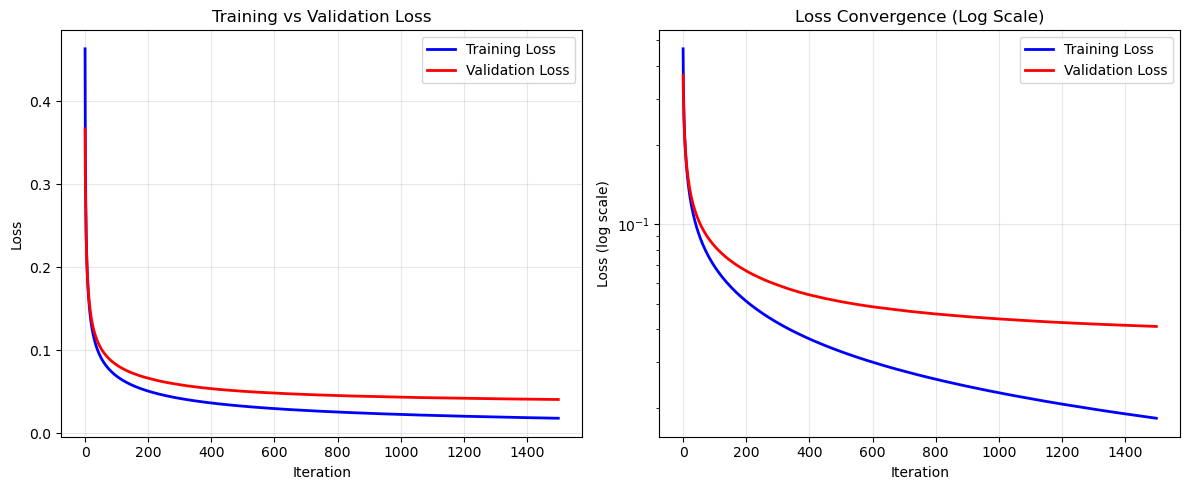

Initial Loss: 0.463238
Final Loss: 0.018356
Loss Reduction: 96.04%
Total Iterations: 1500


In [53]:
model.plot_loss()

## Đánh giá mô hình

In [54]:
_ = calculate_metrics(y_train, np.where(model.predict(X_train) == 1, 'spam', 'ham'), "Training")
print("--------------------------------")
_ = calculate_metrics(y_val, np.where(model.predict(X_val) == 1, 'spam', 'ham'), "Validation")

Metrics for Training:
Accuracy: 0.9966
Precision: 0.9938
Recall: 0.9996
F1 Score: 0.9967


--------------------------------
Metrics for Validation:
Accuracy: 0.9887
Precision: 0.9829
Recall: 0.9949
F1 Score: 0.9889




# Thử nghiệm thực tế

In [55]:
def preprocess_text(subject='', message=''):
    if pd.isnull(subject):
        subject = ''
    if pd.isnull(message):
        message = ''
    return subject + ' ' + message

def predict_email(subject, message, vectorizer, model):
    """
    Predict spam/ham for a single email.
    Args:
        subject (str): Email subject
        message (str): Email body
        vectorizer (CountVectorizer): Fitted vectorizer
        model (LogisticRegression): Trained model
    Returns:
        int: 1 for spam, 0 for ham
    """
    text = preprocess_text(subject, message)
    X = vectorizer.transform([text])
    pred = model.predict(X)[0]
    if type(pred) == np.int32:
        return "spam" if pred == 1 else "ham"
    else:
        return pred

def predict_csv(csv_path, vectorizer, model, label_col='Spam/Ham'):
    """
    Predict and evaluate on a CSV file with columns: Subject, Message, Spam/Ham.
    Args:
        csv_path (str): Path to CSV file
        vectorizer (CountVectorizer): Fitted vectorizer
        model (LogisticRegression): Trained model
        label_col (str): Name of label column
    Returns:
        dict: Metrics (accuracy, precision, recall, f1_score, confusion_matrix)
    """
    df = pd.read_csv(csv_path)
    df['Subject'] = df['Subject'].fillna('')
    df['Message'] = df['Message'].fillna('')
    df['text'] = df['Subject'] + ' ' + df['Message']
    X = vectorizer.transform(df['text'])
    y_true = df[label_col].values
    y_pred = model.predict(X)
    # Convert numeric prediction to label if needed
    if np.issubdtype(y_pred.dtype, np.number): # Checks for any numeric type (int, float)
        # Convert numeric 0/1 to 'ham'/'spam'. Adjust if your model uses different numeric labels.
        y_pred_label = np.array(['spam' if p == 1 else 'ham' for p in y_pred])
    else: # If not numeric, assume it's already string labels; ensure lowercase
        y_pred_label = np.array([str(p).lower() for p in y_pred])
    # Simple metrics
    y_pred_label = np.asarray(y_pred_label)
    TP = np.sum((y_pred_label == 'spam') & (y_true == 'spam'))
    FP = np.sum((y_pred_label == 'spam') & (y_true == 'ham'))
    TN = np.sum((y_pred_label == 'ham') & (y_true == 'ham'))
    FN = np.sum((y_pred_label == 'ham') & (y_true == 'spam'))
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")


## Thử nghiệm với 1 email

In [56]:
import pickle
lr_model = pickle.load(open('Models/lr_model.pkl', 'rb'))
nb_model = pickle.load(open('Models/nb_model.pkl', 'rb'))
bow = pickle.load(open('Models/BoW.pkl', 'rb'))

In [57]:
SUBJECT = None
MESSAGE = None

if not SUBJECT and not MESSAGE:
    SUBJECT = "Hello"
    MESSAGE = "This is a test message"

print("Predicting email with Naive Bayes Classifier: ", end="")
print(predict_email(SUBJECT, MESSAGE, bow, nb_model))
print("--------------------------------")
print("Predicting email with Logistic Regression Classifier: ", end="")
print(predict_email(SUBJECT, MESSAGE, bow, lr_model))
print("--------------------------------")

Predicting email with Naive Bayes Classifier: ham
--------------------------------
Predicting email with Logistic Regression Classifier: 1
--------------------------------


## Thử nghiệm với 1 file csv

In [58]:
import pickle
lr_model = pickle.load(open('Models/lr_model.pkl', 'rb'))
nb_model = pickle.load(open('Models/nb_model.pkl', 'rb'))
bow = pickle.load(open('Models/BoW.pkl', 'rb'))

In [59]:
CSV_PATH = None

if not CSV_PATH:
    CSV_PATH = "val.csv"

print("Predicting email with Logistic Regression Classifier")
predict_csv(CSV_PATH, bow, lr_model)
print("--------------------------------")
print("Predicting email with Naive Bayes Classifier")
predict_csv(CSV_PATH, bow, nb_model)
print("--------------------------------")

Predicting email with Logistic Regression Classifier
Accuracy: 0.9887
Precision: 0.9829
Recall: 0.9949
F1 Score: 0.9889
--------------------------------
Predicting email with Naive Bayes Classifier
Accuracy: 0.9903
Precision: 0.9892
Recall: 0.9917
F1 Score: 0.9904
--------------------------------
